<center>
<img src="https://cdn.megabonus.com/images/shop_logo/skillbox.png"/> 
    
# Курс аналитик данных на Python
## Модуль 3.1. Pandas advanced. Составляем отчетность.

In [1]:
import numpy as np
import pandas as pd
import random

Итак, в этом уроке мы попробуем решить совсем прикладную задачу и научимся работать с табличными данными.<br>
А именно:
* узнаем как работать с файлом, который весит **30+ мегабайт**.;
* посчитаем **базовые статистики** в разных **разрезах и сегментах пользователей** и **уберем выбросы**;
* поймем **как объединить таблицы** по ключу;
* оформим **отчет по среднему чеку по дате и в разрезе категорий** и **отчет по оттоку пользователей**;
* сделаем **отдельную функцию для отправления на почту**;
<br>
Но обо всем по порядку!


Для начала прочитаем данные с помощью библиотеки [**pandas**](http://pandas.pydata.org/pandas-docs/stable/).<br>
Наши довольно большие. Таблица более миллиона строк и в распакованном виде весит около **30 мб**<br>
Это не так много, но вопрос сколько времени excel это будет читать оставляю вам на размышление)

## 1. Загрузим наш файл.

In [12]:
data = pd.read_csv('../SBox/data/mean_check/data.csv.gz', compression='gzip')

Как и прежде, первое с чего нужно начать это с того чтобы понять что перел нами за данные.<br>
Посмотрим на количество строк, колонки и типы данных. Также заметим что в распакованном виде наши **данные раздулись до 53+ мб**.

In [13]:
print('У нас %s строк и %s колонок.'%data.shape)
print('---')
print(data.info())

У нас 1008889 строк и 8 колонок.
---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008889 entries, 0 to 1008888
Data columns (total 8 columns):
mcc             1008889 non-null int64
period          1008889 non-null object
trdatetime      1008889 non-null object
amount          1008889 non-null float64
channel_type    1003825 non-null object
cl_id           1008889 non-null int64
currency        1008889 non-null int64
trx_category    1008889 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 61.6+ MB
None


In [14]:
data.describe()

,mcc,amount,cl_id,currency
count,1.008889e+06,1.008889e+06,1.008889e+06,1.008889e+06
mean,5.695758e+03,5.613910e+03,4.792338e+03,8.106325e+02
std,6.629852e+02,6.258510e+04,2.956989e+03,3.869616e+01
min,7.420000e+02,1.000000e-02,0.000000e+00,3.200000e+01
25%,5.411000e+03,2.200000e+02,2.184000e+03,8.100000e+02
50%,5.661000e+03,6.162000e+02,4.586000e+03,8.100000e+02
75%,5.941000e+03,2.147000e+03,7.350000e+03,8.100000e+02
max,9.405000e+03,3.583500e+07,1.021600e+04,9.860000e+02


И посмотрим на первые 3 строчки.

In [15]:
data.head(3)

,mcc,period,trdatetime,amount,channel_type,cl_id,currency,trx_category
0,5200,01/10/2017,21OCT17:00:00:00,5023.0,NaN,0,810,POS
1,6011,01/10/2017,12OCT17:12:24:07,20000.0,NaN,0,810,DEPOSIT
2,5921,01/12/2017,05DEC17:00:00:00,767.0,NaN,0,810,POS


Сразу можно заметить, что у нас транзакционный датасет. Так как это реальные данные, то некоторые поля заменяются приватными значения, как например тут категория валюты.<br> 

Мы можем посчитать сколько унас валют всего, чтобы понять масштабы.

In [16]:
len(data['currency'].unique())

67

И посмотреть что у нас за категории. Смутно можно понять, что они связаны с типом транзакции, например <br>
`WD_ATM_PARTNER` это снятие с банкомата партнера, а `POS` это потребительский кредит, тоесть оплата с кредитной карты.

In [17]:
data.trx_category.unique()

array(['POS', 'DEPOSIT', 'C2C_OUT', 'WD_ATM_ROS', 'BACK_TRX',
       'WD_ATM_PARTNER', 'WD_ATM_OTHER', 'C2C_IN', 'CAT', 'CASH_ADV'],
      dtype=object)

In [18]:
data.head()

,mcc,period,trdatetime,amount,channel_type,cl_id,currency,trx_category
0,5200,01/10/2017,21OCT17:00:00:00,5023.0,NaN,0,810,POS
1,6011,01/10/2017,12OCT17:12:24:07,20000.0,NaN,0,810,DEPOSIT
2,5921,01/12/2017,05DEC17:00:00:00,767.0,NaN,0,810,POS
3,5411,01/10/2017,21OCT17:00:00:00,2031.0,NaN,0,810,POS
4,6012,01/10/2017,24OCT17:13:14:24,36562.0,NaN,0,810,C2C_OUT


Сразу бросается в глаза дата транзакции и ее формат, поэтому давайте приведем ее в нормальный вид.<br>
А так же отдельные колонки для года/месяца/дня/времени и соединим месяц с годом, для удобства <br>
(так как у нас данные за несколько лет), чтобы потом сделать помесячные отчеты.<br>
Чтобы не потерять и не испортить данные, лучше делать отдельные колонки.

In [19]:
# преобразование даты
data['period'] = pd.to_datetime(data['period'], format='%d/%m/%Y')

# преобразование времени
data['transac_time'] = data['trdatetime'].str[-11:-3]

# разные компоненты даты по столбцам
data['transac_day'] = data['trdatetime'].str[:2]
month_dict={'JAN':'01', 'FEB':'02', 'MAR':'03', 'APR':'04', 'MAY':'05', 'JUN':'06', 
            'JUL':'07', 'AUG':'08', 'SEP':'09', 'OCT':'10', 'NOV':'11', 'DEC':'12'}
data['transac_month'] = data['trdatetime'].str[2:5].map(month_dict)
data['transac_year'] = '20'+data['trdatetime'].str[5:7]

# комбинированное поле месяц-год
#data['transac_year_month'] = data['period'].apply(lambda x: x.strftime('%m-%Y')) 
data['transac_year_month'] = '20'+data['trdatetime'].str[5:7]+'-'+data['trdatetime'].str[2:5].map(month_dict)

In [20]:
data.head(3)

,mcc,period,trdatetime,amount,channel_type,cl_id,currency,trx_category,transac_time,transac_day,transac_month,transac_year,transac_year_month
0,5200,2017-10-01,21OCT17:00:00:00,5023.0,NaN,0,810,POS,17:00:00,21,10,2017,2017-10
1,6011,2017-10-01,12OCT17:12:24:07,20000.0,NaN,0,810,DEPOSIT,17:12:24,12,10,2017,2017-10
2,5921,2017-12-01,05DEC17:00:00:00,767.0,NaN,0,810,POS,17:00:00,05,12,2017,2017-12


Отлично, давайте теперь посмотрим на экстримальные значения наших транзакций.

In [21]:
data.groupby('currency')['amount'].agg(['min', 'mean', 'median','max']).tail()

,min,mean,median,max
currency,,,,
978,0.01,105.797974,29.00,9690.00
980,1.50,885.639098,282.00,15451.17
981,0.80,94.718251,35.62,1306.00
985,0.99,101.715674,35.67,4800.00
986,6.00,88.106471,60.00,260.00


Ок, но не ясно что за валюты, может где-то можно найти соотвествие числовых кодов и хотябы привычных<br>
трехбуквенных кодов вида **USD**, **EUR**, **RUB**?

## 2. Расшифруем валютные коды.

In [22]:
wiki_table = pd.read_csv('../SBox/data/mean_check/currency_codes_wiki.csv')
wiki_table.head()

,num_code,currency_code,title
0,784,AED,United Arab Emirates dirham
1,971,AFN,Afghan afghani
2,8,ALL,Albanian lek
3,51,AMD,Armenian dram
4,532,ANG,Netherlands Antillean guilder


In [23]:
wiki_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 3 columns):
num_code         179 non-null int64
currency_code    179 non-null object
title            178 non-null object
dtypes: int64(1), object(2)
memory usage: 4.3+ KB


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008889 entries, 0 to 1008888
Data columns (total 13 columns):
mcc                   1008889 non-null int64
period                1008889 non-null datetime64[ns]
trdatetime            1008889 non-null object
amount                1008889 non-null float64
channel_type          1003825 non-null object
cl_id                 1008889 non-null int64
currency              1008889 non-null int64
trx_category          1008889 non-null object
transac_time          1008889 non-null object
transac_day           1008889 non-null object
transac_month         1008889 non-null object
transac_year          1008889 non-null object
transac_year_month    1008889 non-null object
dtypes: datetime64[ns](1), float64(1), int64(3), object(8)
memory usage: 100.1+ MB


Переведем наши поля по которым будем мэтчить в один тип данных. Я выбрал `int`.<br>
Приводить значения в таблице `wiki_table` нам не надо так как они уже в `int`.

In [25]:
#wiki_table['num_code'] = wiki_table['num_code'].astype(int)
data['currency'] = data['currency'].astype(int)

Чтобы совместить таблички нам нужно их "смерджить", то есть применить метод **.merge**, который дословно значит "слить".<br>
Итак, смерджить таблички можно по-разному, как схематически показано ниже. И в зависимости от смысла задачи может требоваться <br>
разный вид мерджа. В нашем случае нам нужен левый (left), чтобы притянуть все значения к левой табличке.<br>
Про объединение таблиц и различного рода совмещения очень хорошо написано с примерами в [документации](https://pandas.pydata.org/pandas-docs/stable/merging.html).
<img src="https://shanelynnwebsite-mid9n9g1q9y8tt.netdna-ssl.com/wp-content/uploads/2017/03/join-types-merge-names.jpg"/> 

In [26]:
data.merge(wiki_table, left_on='currency', right_on='num_code', how='left').head()

,mcc,period,trdatetime,amount,channel_type,cl_id,currency,trx_category,transac_time,transac_day,transac_month,transac_year,transac_year_month,num_code,currency_code,title
0,5200,2017-10-01,21OCT17:00:00:00,5023.0,NaN,0,810,POS,17:00:00,21,10,2017,2017-10,NaN,NaN,NaN
1,6011,2017-10-01,12OCT17:12:24:07,20000.0,NaN,0,810,DEPOSIT,17:12:24,12,10,2017,2017-10,NaN,NaN,NaN
2,5921,2017-12-01,05DEC17:00:00:00,767.0,NaN,0,810,POS,17:00:00,05,12,2017,2017-12,NaN,NaN,NaN
3,5411,2017-10-01,21OCT17:00:00:00,2031.0,NaN,0,810,POS,17:00:00,21,10,2017,2017-10,NaN,NaN,NaN
4,6012,2017-10-01,24OCT17:13:14:24,36562.0,NaN,0,810,C2C_OUT,17:13:14,24,10,2017,2017-10,NaN,NaN,NaN


**WAT DA HELL?**

Хух, ну вроде все верно, но что не так?

In [27]:
data.merge(wiki_table, left_on='currency', right_on='num_code', how='left')['num_code'].unique()

array([ nan, 978., 504., 704., 981., 985., 840., 949.,  51., 826., 214.,
       764., 203., 702., 360., 756., 933., 975.,  36., 191., 784., 980.,
       124., 398., 376., 944., 352., 417., 156., 752., 392., 484., 634.,
       188., 643., 348., 356., 458., 986., 498., 578., 208., 344.,  32.,
       410., 788., 480., 604., 941., 144., 946., 710., 690.,  44., 170.,
       901., 608., 554., 462., 800., 977., 496., 516.,  48., 446., 404.,
       524.])

Дело в том, что в российских банках транзакции учитываюсь с кодом 810, который был введен **еще до деноминации 1998 года.** <br>
<center>
<img src="https://cs5.pikabu.ru/post_img/2015/12/04/5/1449210847155432089.jpg"/> 
    
А в международном стандарте у России код: 643, что мы и можем видеть в таблице ниже.<br>
Внутренний код для платежей в рублях до сих пор 810, что немного смущет, если честно.<br>
Вокруг этого ходит довольно много баек и мифов, но с другой стороны, по сути это всего лишь дирекция ЦБ России <br>
и присутствие того или иного кода в платежке ни на что не влияет существенным образом.<br>
Тем не менее, кому интересно, больше можно почитать [тут](https://goo.gl/Jb5rQG) и конкретно [тут](https://fincult.info/articles/valyuty/mify-i-pravda-o-valyutnykh-kodakh-rublya/).<br>
Но вернемся к делу!

In [28]:
wiki_table[wiki_table['title'] == 'Russian ruble']

,num_code,currency_code,title
120,643,RUB,Russian ruble


In [29]:
wiki_table[wiki_table['title'].isin(["United States dollar","Afghan afghani"])]

,num_code,currency_code,title
1,971,AFN,Afghan afghani
148,840,USD,United States dollar


Поправим немного нашу таблицу, чтобы мы могли классифицировать наши транзакции полностью.

In [30]:
wiki_table = wiki_table.append({'num_code': 810, 'currency_code':'RUR','title':'Russian ruble'},ignore_index=True)

В этот раз сохраним наши измениея, переназначив объект.

In [31]:
data = data.merge(wiki_table, left_on='currency', right_on='num_code', how='left')
data.head()

,mcc,period,trdatetime,amount,channel_type,cl_id,currency,trx_category,transac_time,transac_day,transac_month,transac_year,transac_year_month,num_code,currency_code,title
0,5200,2017-10-01,21OCT17:00:00:00,5023.0,NaN,0,810,POS,17:00:00,21,10,2017,2017-10,810,RUR,Russian ruble
1,6011,2017-10-01,12OCT17:12:24:07,20000.0,NaN,0,810,DEPOSIT,17:12:24,12,10,2017,2017-10,810,RUR,Russian ruble
2,5921,2017-12-01,05DEC17:00:00:00,767.0,NaN,0,810,POS,17:00:00,05,12,2017,2017-12,810,RUR,Russian ruble
3,5411,2017-10-01,21OCT17:00:00:00,2031.0,NaN,0,810,POS,17:00:00,21,10,2017,2017-10,810,RUR,Russian ruble
4,6012,2017-10-01,24OCT17:13:14:24,36562.0,NaN,0,810,C2C_OUT,17:13:14,24,10,2017,2017-10,810,RUR,Russian ruble


Вот теперь совсем все хорошо и у нас все транзакции размечены нормальными названиями валют в которых они были совершены.
Напомню, что числовы коды у нас типа `int`.

In [32]:
data[data['num_code'] == 810].head(3)

,mcc,period,trdatetime,amount,channel_type,cl_id,currency,trx_category,transac_time,transac_day,transac_month,transac_year,transac_year_month,num_code,currency_code,title
0,5200,2017-10-01,21OCT17:00:00:00,5023.0,NaN,0,810,POS,17:00:00,21,10,2017,2017-10,810,RUR,Russian ruble
1,6011,2017-10-01,12OCT17:12:24:07,20000.0,NaN,0,810,DEPOSIT,17:12:24,12,10,2017,2017-10,810,RUR,Russian ruble
2,5921,2017-12-01,05DEC17:00:00:00,767.0,NaN,0,810,POS,17:00:00,05,12,2017,2017-12,810,RUR,Russian ruble


Пропусков нет! Мы разметили все транзакции.

In [33]:
data['title'].isna().value_counts()

False    1008889
Name: title, dtype: int64

Вернемся к нашей сгруппированной табличке.

In [34]:
data.groupby('title')['amount'].agg(['min', 'mean', 'median','max']).tail()

,min,mean,median,max
title,,,,
Ugandan shilling,855000.00,8.550000e+05,855000.00,855000.00
Ukrainian hryvnia,1.50,8.856391e+02,282.00,15451.17
United Arab Emirates dirham,2.00,4.905544e+02,96.00,24704.40
United States dollar,0.01,1.735173e+02,34.49,50000.00
Vietnamese đồng,10700.00,1.806074e+06,757500.00,35835000.00


И сделаем её немного читабельнее.<br>
Стоит заметить, что сортировка происходит по индексу, так что в случае с числовым кодом и названием валюты у нас <br>
будет разный порядок.

In [35]:
data.groupby('title')['amount'].agg(['min', 'mean', 'median','max']).tail().apply(lambda x:round(x,0))

,min,mean,median,max
title,,,,
Ugandan shilling,855000.0,855000.0,855000.0,855000.0
Ukrainian hryvnia,2.0,886.0,282.0,15451.0
United Arab Emirates dirham,2.0,491.0,96.0,24704.0
United States dollar,0.0,174.0,34.0,50000.0
Vietnamese đồng,10700.0,1806074.0,757500.0,35835000.0


In [36]:
data[(data['num_code'].isin([840,978]))].groupby('title')["amount"].mean()


title
Euro                    105.797974
United States dollar    173.517300
Name: amount, dtype: float64

## 3. Расшифруем MCC коды.

Также в интренете можно найти информаци о [MCC](https://en.wikipedia.org/wiki/Merchant_category_code). Это стандартизированный код категории покупки, который устанавливается на кассы предприятия. Потом банки исходя из этих кодов могут начислять кэшбек или бонусы за проведенные транзакции, если это предуматривает Ваш тариф. Имея текстовые репрезентации этих кодов довольно сильно поможет нам при построении осмысленного отчета.<br>

У нас есть табличка с различными mcc кодами и их интерпритацией, которую я просто нагуглил.

In [38]:
mcc = pd.read_excel('../SBox/data/mean_check/mcc_codes.xls')

In [39]:
mcc.head()

,STANDARD MERCHANT CATEGORY CODES **Please do not sort this spreadsheet**,Unnamed: 1,Unnamed: 2
0,MCC CODE,Program Type:,NaN
1,0742,Veterinary Services,NaN
2,0763,Agricultural Cooperatives,NaN
3,0780,Landscaping and Horticultural Services,NaN
4,1520,General Contractor/Residential Building,NaN


Очень часто бывае что эксель попадает в таком виде. Чтобы получить красивую табличку нужно пропустить первый ряд и убрать правую колонку с пустыми значениями. Так и сделаем:

In [40]:
mcc = pd.read_excel('../SBox/data/mean_check/mcc_codes.xls',skiprows=1)
mcc = mcc.iloc[:,:-1]
mcc.head()

,MCC CODE,Program Type:
0,742.0,Veterinary Services
1,763.0,Agricultural Cooperatives
2,780.0,Landscaping and Horticultural Services
3,1520.0,General Contractor/Residential Building
4,1711.0,"Heating, Plumbing, Air Conditioning Contractors"


И переименуем колонки для красоты и удобства.

In [41]:
mcc = mcc.rename(columns={'MCC CODE':'mcc','Program Type:':'category'})

In [42]:
mcc.head()

,mcc,category
0,742.0,Veterinary Services
1,763.0,Agricultural Cooperatives
2,780.0,Landscaping and Horticultural Services
3,1520.0,General Contractor/Residential Building
4,1711.0,"Heating, Plumbing, Air Conditioning Contractors"


Объедним по категории к нашей общей таблице (левый мердж). <br>

In [43]:
data = data.merge(mcc, on='mcc', how='left')

In [44]:
data.head(3)

,mcc,period,trdatetime,amount,channel_type,cl_id,currency,trx_category,transac_time,transac_day,transac_month,transac_year,transac_year_month,num_code,currency_code,title,category
0,5200,2017-10-01,21OCT17:00:00:00,5023.0,NaN,0,810,POS,17:00:00,21,10,2017,2017-10,810,RUR,Russian ruble,Home Supply Warehouse
1,6011,2017-10-01,12OCT17:12:24:07,20000.0,NaN,0,810,DEPOSIT,17:12:24,12,10,2017,2017-10,810,RUR,Russian ruble,Financial Institutions--Automated Cash Disburs...
2,5921,2017-12-01,05DEC17:00:00:00,767.0,NaN,0,810,POS,17:00:00,05,12,2017,2017-12,810,RUR,Russian ruble,"Package Stores--Beer, Wine, and Liquor"


Проверим сколько у нас категорий не подтянулось с помощью методов **.isna()** и **.value_counts()**.

In [45]:
data.category.isna().value_counts()

False    1008888
True           1
Name: category, dtype: int64

In [46]:
data.mcc.isna().value_counts()

False    1008889
Name: mcc, dtype: int64

Действительно, в силу тех или иных причин мы не смогли индифицировать всего лишь 1 код, так что мы можем этим пренебречь.

## 4.  Отчет по средним тратам.

Давайте уже построим отчет! Для этих целей отберем только рублевые транзакции и сделаем табличку в разрезе категория-даты.<br>

Также, тк природа данных это покупки/транзакции, то присутствуют экстримальные значения, которые будут искажать среднее по больнице.
Поэтому мы **отбросим по 5% максимальных значений и столько же минимальных**. Это называется **очисткой от выбросов** и для этого нам понадобится посчитать квартили и применить фильтрацию.

In [47]:
report = pd.DataFrame()
currency = 810
rubbles = data[data['currency'] == currency]
dates = sorted(rubbles['transac_year_month'].unique())


for date in dates:
    buffer = rubbles[rubbles['transac_year_month'] == date][['transac_year_month','amount','category']].set_index(['transac_year_month','category'])

    low = .05
    high = .95
    quant_df = buffer.quantile([low, high])

    filtered_df = buffer.apply(lambda x: x[(x>quant_df.loc[low,x.name]) & (x < quant_df.loc[high,x.name])], axis=0)
    filtered_df = filtered_df.reset_index().groupby(['transac_year_month','category']).mean()

    report = pd.concat([report, filtered_df]) # объединяем нашу таблицу

report = report.unstack().T # разворачиваем нашу таблицу 
report = round(report,2)

In [48]:
report.head()

transac_year_month                                       2016-10   2016-11  \
       category                                                              
amount AIR STANA                                             NaN       NaN   
       Accounting, Auditing, and Bookkeeping Services        NaN   2294.42   
       Advertising Services                              1306.57   2674.30   
       AeroFlot                                         20423.09  12961.51   
       Agricultural Cooperatives                             NaN       NaN   

transac_year_month                                       2016-12   2017-01  \
       category                                                              
amount AIR STANA                                             NaN  14061.00   
       Accounting, Auditing, and Bookkeeping Services        NaN    960.00   
       Advertising Services                              1863.58   1367.67   
       AeroFlot                                         13992.32   8480.99   
       Agricultural Cooperatives                             NaN    702.00   

transac_year_month                                       2017-02   2017-03  \
       category                                                              
amount AIR STANA                                        10977.00       NaN   
       Accounting, Auditing, and Bookkeeping Services        NaN       NaN   
       Advertising Services                              1071.13   1117.51   
       AeroFlot                                          9766.56  11490.96   
       Agricultural Cooperatives                          624.00       NaN   

transac_year_month                                      2017-04  2017-05  \
       category                                                            
amount AIR STANA                                            NaN      NaN   
       Accounting, Auditing, and Bookkeeping Services       NaN   290.00   
       Advertising Services                             1783.02  1130.19   
       AeroFlot                                         9601.84  8756.14   
       Agricultural Cooperatives                        1879.50  1440.00   

transac_year_month                                       2017-06   2017-07  \
       category                                                              
amount AIR STANA                                        14092.00  11113.67   
       Accounting, Auditing, and Bookkeeping Services        NaN       NaN   
       Advertising Services                              1490.12   2049.76   
       AeroFlot                                         10632.52   9061.11   
       Agricultural Cooperatives                         1531.50       NaN   

transac_year_month                                       2017-08  2017-09  \
       category                                                             
amount AIR STANA                                        10691.00      NaN   
       Accounting, Auditing, and Bookkeeping Services        NaN   720.00   
       Advertising Services                              1517.03  1700.32   
       AeroFlot                                         10445.11  9230.78   
       Agricultural Cooperatives                             NaN   174.00   

transac_year_month                                      2017-10   2017-11  \
       category                                                             
amount AIR STANA                                            NaN       NaN   
       Accounting, Auditing, and Bookkeeping Services       NaN       NaN   
       Advertising Services                             2955.57    533.81   
       AeroFlot                                         9766.24  16065.27   
       Agricultural Cooperatives                            NaN       NaN   

transac_year_month                                       2017-12   2018-01  \
       category                                                              
amount AIR STANA                           

In [49]:
def do_report(dataframe, currency_int):
    """
    Данная функция делает отчет по аналогии с тем что мыы делали выше, но принимает на вход таблицу и значение валюты
    по которым нужно построить отчет.
    
    Сначала мы создаем пустую таблицу в которую будем добавлять уже посчитанные значения.
    Далее создаем срез из переданной таблицы и создаем отсортированный вектор дат.
    
    После этого начинается цикл, которй бегает по сформированному срезу и берет транзакции по определенной дате и 
    выбирает значения ['transac_year_month','amount','category'].
    
    Далее рассчитаывается .05 и .95 квартиль распределения. По сути мы отбрасываем по 5% максимальных значений и 
    столько же минимальных, тем самым очищая от выбросов, которые могут исказить наши средние значения.
    После того как рассчитали пороги, мы приминяем фильтрацию и получаем очищенную табличку.
    
    Присоединяем ее к созданной в начале с помощью метода pd.concat, разворачиваем и транспонируем.

    """
    
    report = pd.DataFrame()
    currency = currency_int
    df = dataframe[dataframe['currency'] == currency]
    dates = sorted(df['transac_year_month'].unique())


    for date in dates:
        buffer = df[df['transac_year_month'] == date][['transac_year_month','amount','category']].set_index(['transac_year_month','category'])

        # посчитаем значения квартилей по которым будем обрезать наши значния в транзакциях
        low = .05
        high = .95
        quant_df = buffer.quantile([low, high])

        # отфильтруем значения 
        filtered_df = buffer.apply(lambda x: x[(x>quant_df.loc[low,x.name]) & (x < quant_df.loc[high,x.name])], axis=0)
        filtered_df = filtered_df.reset_index().groupby(['transac_year_month','category']).mean()

        # объединяем нашу посчитанную таблицу с главной
        report = pd.concat([report, filtered_df])

    # разворачиваем нашу таблицу, транспонируем и удаляем одну колонку по которой индексировались - непростое комбо!
    report = report.unstack().T
    
    """
    P.S. Пофиксили случай, когда у нас получается слишком маленький отчет и наше отсечение порогов захватывает все записи и у нас
    остается пустой отчет, который приводит к ошибке в следующей функции, которая записывает отчет в excel.
    Я решил написать просто дополнение, а не переписывать функцию полностью.
    """
    if report.shape[0] == 0: # сравниваем длину нашего отчета с нулем. если да, то делаем операции внутри цикла.
        
        report = pd.DataFrame() # обнуляем наш отчет
        
        # для каждой из дат считаем все теже операции, что и выше, но без отсечения выбросов.
        for date in dates:
            buffer = df[df['transac_year_month'] == date][['transac_year_month','amount','category']].set_index(['transac_year_month','category'])
            buffer = buffer.groupby(['transac_year_month','category']).mean()
            report = pd.concat([report, buffer])
            return round(report,2) # возвращаем таблицу с округленными значениями
    else:
        return round(report,2)

In [50]:
rep = do_report(data,810)
rep

transac_year_month                                          2016-10   2016-11  \
       category                                                                 
amount AIR STANA                                                NaN       NaN   
       Accounting, Auditing, and Bookkeeping Services           NaN   2294.42   
       Advertising Services                                 1306.57   2674.30   
       AeroFlot                                            20423.09  12961.51   
       Agricultural Cooperatives                                NaN       NaN   
       Air China                                                NaN       NaN   
       Air Conditioning and Refrigeration Repair Shops          NaN       NaN   
       Air France                                               NaN       NaN   
       Air Malta                                                NaN       NaN   
       Airlines and Air Carriers                           12722.28   8273.79   
       Airports, Flying Fields, and Airport Terminals           NaN       NaN   
       Alitalia                                                 NaN  18524.00   
       American Airlines                                        NaN       NaN   
       Amusement Parks, Circuses, Carnivals, and Fortu...  16597.50   1103.00   
       Antique Shop                                        16757.56       NaN   
       Aquarium, Seaquarium, Dolphinariums                      NaN    533.33   
       Architectural, Engineering, and Surveying Services       NaN       NaN   
       Art Dealers and Galleries                                NaN  13780.00   
       Artist Supply and Craft Stores                           NaN   2031.33   
       Austrian Airlines                                        NaN       NaN   
       Automated Fuel Dispensers                            1116.58   1353.22   
       Automobile Associations                                  NaN       NaN   
       Automobile Rental Agency                             9500.00    875.00   
       Automotive Paint Shops                                   NaN       NaN   
       Automotive Parts and Accessories Stores              6064.02   3347.08   
       Automotive Service Shops (Non-Dealer)               10424.46   4330.27   
       Automotive Tire Stores                               8876.67   5502.26   
       Automotive Top & Body Shops                              NaN   7955.00   
       Bakeries                                              319.25    416.09   
       Bands, Orchestras & Misc Entertainment                   NaN   5183.33   
...                                                             ...       ...   
       Taj Hotels International                                 NaN       NaN   
       Tax Payments                                             NaN       NaN   
       Tax Preparation Services                                 NaN       NaN   
       Taxicabs and Limousines                               434.92    305.84   
       Telecommunication Equipment and Telephone Sales      2273.84   3972.32   
       Telecommunication Services, Including Local and...   1094.91   1158.42   
       The Ritz Carlton Hotels                                  NaN       NaN   
       Theatrical Producers (except Motion Pictures) a...   3257.50   3397.61   
       Timeshares                                               NaN       NaN   
       Tire Retreading & Repair                                 NaN       NaN   
       Tourist Attractions and Exhibits                         NaN    878.11   
       Towing Services                                          NaN   4800.00   
       Trade and Vocational Schools                             NaN       NaN   
       Trailer Parks and Campgrounds                            NaN       NaN   
       Transportation Services-not elsewhere classified     3236.86   1574.11   
       Travel Agencies                                     10709.48   8252.44   
       Typesetting, Plate Makin

Проверим. Работает!

Осталось только проделать это все для каждой категории транзакций, записать на отдельный лист и записать в эксельник.<br>
Ниже я написал функуцию, которая циклично добавляет табличку на новыый лист с названием этой таблицы.

In [58]:
def write_excel_cyclicaly(dataframe, dataframe_name):
    import openpyxl
    """
    Эта функция циклично добавляет табличку на новыый лист с названием этой таблицы, используя конструкцию with.
    
    """

    with pd.ExcelWriter('../SBox/data/mean_check/results/report.xlsx', engine='openpyxl') as writer:
        writer.book = book
        writer.sheets = dict((ws.title, ws) for ws in book.worksheets)    

        dataframe.to_excel(writer, '{}'.format(str(dataframe_name)))
        writer.save()  

Осталось немного. А именно нам нужно создать/инициализировать пустой файл эксель отчета и произвести в него запись,<br>
получившихся таблиц.

In [60]:
# определяем транзакционные категории конкретно для выбранного нами кода валюты
trx_cats = data[data['currency'] == 810]['trx_category'].unique()

# создаем/инициализируем файл 
import openpyxl
filepath = "../SBox/data/mean_check/results/"
book = openpyxl.Workbook()
book.save(filepath+'report.xlsx')

# цикл создания отчетов и записи в эксель файл
for trx_cat in trx_cats:
    report = do_report(data[data['trx_category'] == trx_cat], 810)
    write_excel_cyclicaly(report, '{}'.format(trx_cat))

## 5. Отчет по оттоку.

Отток, или **churn** можно определять по-разному, например в зависимости от периода.<br>
Так же понятие оттока довольно тесно связано с удержанием или **retention**. Это напротив, сколько людей у нас остается на протяжении из месяца в месяц работы сервиса/подписки и приносит деньги.
Давайте посчитаем классический месячныый отток, тоесть проверим сколько людей уходили в текущий месяц, сравнивая его с предыдущим.

In [61]:
data.head(3)

,mcc,period,trdatetime,amount,channel_type,cl_id,currency,trx_category,transac_time,transac_day,transac_month,transac_year,transac_year_month,num_code,currency_code,title,category
0,5200,2017-10-01,21OCT17:00:00:00,5023.0,NaN,0,810,POS,17:00:00,21,10,2017,2017-10,810,RUR,Russian ruble,Home Supply Warehouse
1,6011,2017-10-01,12OCT17:12:24:07,20000.0,NaN,0,810,DEPOSIT,17:12:24,12,10,2017,2017-10,810,RUR,Russian ruble,Financial Institutions--Automated Cash Disburs...
2,5921,2017-12-01,05DEC17:00:00:00,767.0,NaN,0,810,POS,17:00:00,05,12,2017,2017-12,810,RUR,Russian ruble,"Package Stores--Beer, Wine, and Liquor"


In [62]:
"""
В этом куске кода мы будем искать оттекших пользователей тоесть cl_id, которых нет в этом месяце, но есть в прошлом. 
С точки зрения банковской деятельности это вобщем-то обосновано и у нас как раз транзакционные данные. В случае если 
это какой-то продукт, то возможно стоит увеличить окно в зависимости от бизнес процессов.

`del previous, current` - Строчка которая, удаляет вектора 
Если вылезла ошибка, то нужно просто закомментировать, а потом раскомментировать, чтобы первая ячейка была всегда np.nan, 
потому что мы считаем отношение к прошлом месяцу, данными к которым мы еще не обладаем.

1) Используем цикл с возможностью отловить ошибку: try ... except, который позволит нам не завершать цикл если вылезет ошибка.
А ошибка у нас вылезает в случае, если у нас нет значения за прошлый период. 
2) Находим вектор айдишников пользователей в текущем месяце.
3) Находим пересечение с прошлым месяцем, точнее инфертированное пересечение или те значения, которых нет в текущем месяце, 
сравнивая с предыдущим. У нас возвращается вектор True/False значений.
P.S. На этом этапе у нас появляется ошибка в когда мы сравниваем первый месяц с прыдыдущего, которого у нас нет. У нас возникает
ошибка, которую мы отлавливает и исполняем код в после except.
4) Мы индексируемся, используя вектор True/False значений, получая только значения айдишников пользователей.
5) Считаем длину вектора или по-другому количество "оттекших" пользователей.
6) Переназначаем текущий вектор айдишников на прошлый период, чтобы сравнивать уже со следующим периодом.

"""

# del previous, current 
churn_array = []

for month in sorted(data['transac_year_month'].unique()):
    # 1
    try:
        # 2
        current = data[data['transac_year_month'] == month]['cl_id'].unique()
        # 3
        churned_idx = np.isin(previous, current, invert=True) 
        # 4
        churned = previous[churned_idx] 
        # 5
        churn_array.append(len(churned))
        # 6
        previous = current
    except NameError:
        churn_array.append(np.nan)
        # 7
        previous = data[data['transac_year_month'] == month]['cl_id'].unique()

In [63]:
churn_table = pd.DataFrame({'months':sorted(data['transac_year_month'].unique()),
                            'churn':churn_array
                           }, columns=['months','churn'])

churn_table

,months,churn
0,2016-10,NaN
1,2016-11,21.0
2,2016-12,107.0
3,2017-01,313.0
4,2017-02,919.0
5,2017-03,1220.0
6,2017-04,1155.0
7,2017-05,595.0
8,2017-06,841.0
9,2017-07,946.0


Запишем наш файл.

In [64]:
churn_table.to_csv('../SBox/data/mean_check/results/churn.csv',index=False)

Построим минимальный график, чтобы немного затронуть нашу следующую тему- визуализацию.

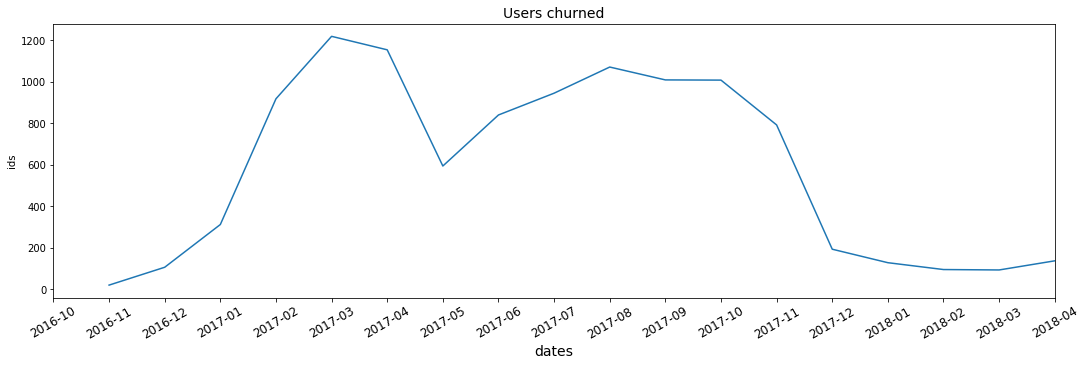

In [66]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(15,5))
churn_table['churn'].plot()

plt.xlabel('dates', fontsize=14)
ax = plt.gca()
plt.xticks(np.arange(0, len(dates), 1.0))
ax.set_xticklabels(churn_table['months'], fontsize=12, rotation=30)
plt.tight_layout()

plt.ylabel('ids')
plt.xlabel('dates')
plt.title('Users churned', fontsize=14)
plt.savefig('../SBox/data/mean_check/results/churn.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Посылаем файлы на почту.

Эта монстр функция посылает прогноз по почте указаным адресам.<br>
Не обязатально понимать сразу все что написано внутри, можно разобрать это по-тихоньку по этапам.

In [ ]:
def send_email(mail_from, password, subject):  

    """
    Эта функция посылает файл/файлы по почте указаным адресам.
    
    1) Константы и переменные которые остаются неизменными, либо меняются нечасто.
    2) Параметры для письма.
    3) Список всех путей до документов, которые нужно послать.
    4) Цикл для присоединения документов к письму.
    5) Цикл для посылки письма. Тестирует на соединение и посылает письмо.
    
    """
    import smtplib, os, sys
    from email.mime.multipart import MIMEMultipart
    from email.mime.text import MIMEText
    from email.mime.base import MIMEBase
    from email import encoders
    
    # 1
    RESULTS_PATH = '../data/mean_check/'
    SENDER = str(mail_from)
    PASSWORD = str(password)
    RECEPIENTS = 'maximkeremet@gmail.com','maximkeremet@ya.ru'
    COMMASPACE = ', '
    
    # 2
    outer = MIMEMultipart()
    outer['Subject'] = subject
    outer['To'] =  COMMASPACE.join(RECEPIENTS) #RECEPIENTS
    outer['From'] = SENDER
    #outer.preamble = ''

    # 3
    ATTACHEMENTS = ['../data/mean_check/results/report.xlsx',
                    '../data/mean_check/results/churn.csv',
                   '../data/mean_check/results/churn.png'] 

    # 4
    for file in ATTACHEMENTS:
        try:
            with open(file, 'rb') as fp:
                msg = MIMEBase('application', "octet-stream")
                msg.set_payload(fp.read())
            encoders.encode_base64(msg)
            msg.add_header('Content-Disposition', 'attachment', filename=os.path.basename(file))
            outer.attach(msg)
        except:
            print("Unable to open one of the attachments. Error: ", sys.exc_info()[0])
            raise

    COMPOSED = outer.as_string()

    # 5
    try:
        with smtplib.SMTP('smtp.gmail.com', 587) as s:
            s.ehlo()
            s.starttls()
            s.ehlo()
            s.login(SENDER, PASSWORD)
            s.sendmail(SENDER, RECEPIENTS, COMPOSED)
            s.close()
    except:
        print("Unable to send the email. Error: ", sys.exc_info()[0])
        raise

Функция не быстрая, немного подумает, но все отработает.<br>
При желаниии ее можно немного переделать, например переместив возможность задавать пути до файлов как аргументы для самой функции.

In [ ]:
send_email('maximkeremet@gmail.com', 'gWmqYzkAVhfT8Hs', 'мой первый отчет')

### Домашнее задание

Практическая часть домашнего задания на этой неделе будет довольно объемным: 

1) Нужно поиграться с ноутбуком и подкрутить скрипт для подобного отчета **по долларам США** и еще одной валюте на выбор. Смело копируйте этот ноутбук и сделайте так, чтобы **отчет о транзакциях** был **в одном файле экселя** и пошлите себе **файлик на почту**.<br>

2) Отток мы посчитали, как на счет посчитать retention? Или сколько пользователей в текущем месяце присутствуют в прошлом месяце. (по сути это ***обратная*** или ***инвертированная задача*** для той что уже мы посчитали.)

3) И свободная часть: **реализовать похожий скрипт для своих нужд** и со своими данными.<br>

**P.S.** В функции `send_email` можете указать несколько адресатов в поле `RECEPIENTS` через запятую.
В таком случае нужно будет раскомментировать параметр `COMMASPACE = ', '` (убрать решетку до него) и заменить `RECEPIENTS` на `COMMASPACE.join(RECEPIENTS)` так же без решетки.